In [1]:
# Python ≥3.5 is required
import sys

assert sys.version_info >= (3, 5)

# Tensorflow ≥ 2.0 is required

# Common imports
import numpy as np
import pandas as pd
import os
import time
import cv2
# flow_vis library implements Middlebury flow vector coloring
import flow_vis
# Maybe use flowpy instead which can read/write png and flo files in KITTI and Middleburry format respectively.
from flow_util import * 


# To plot pretty figures - source Aurelien Geron
import matplotlib.pyplot as plt

plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

import os
import tensorflow as tf
import tensorflow_datasets as tfds

# For some reason we seem to need to load tf onto the GPU first
dummy = tf.constant( 32 )
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
PROJECT_ROOT_DIR = os.getcwd()
NB_ID = "project"

os.makedirs(os.path.join(PROJECT_ROOT_DIR, "tb_logs", NB_ID), exist_ok=True)

# create the directory if it does not exist
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, "images", NB_ID)
os.makedirs(IMAGE_DIR, exist_ok=True)


def save_fig_nb(fig_id):
    path = os.path.join(IMAGE_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    plt.savefig(path, format="png", dpi=300)

def get_logdir(add=""):
    log_id = time.strftime("log_%Y_%m_%d-%H_%M_%S")
    return os.path.join(PROJECT_ROOT_DIR, "tb_logs", NB_ID, log_id + add)

# to make this notebook's output stable across runs
def reset_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)


def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8), interpolation="nearest")
    plt.axis("off")

## Data Loading

The dataset is packaged as a Tensorflow dataset in three sub categories.


In [3]:
tfds.disable_progress_bar()

print(PROJECT_ROOT_DIR)

data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data')
os.makedirs(data_path, exist_ok = True)

print("Using directory: ", data_path)

# flow_data_set = tfds.load('elg7186_projectdata/linear_movement_rotate')
# flow_data_set = tfds.load('elg7186_projectdata/rotation_rotate')
flow_data_set = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)

# Set up an iterator over the data
iter_data = iter(flow_data_set['train'])
# Get the first video
train_data = next(iter_data)

C:\Users\DEBI\Downloads\segmentation
Using directory:  C:\Users\DEBI\Downloads\segmentation\tensorflow_data


## Explore the Data
Let's look at the data_records themselves.

Data has format: <class 'dict'>
dict_keys(['background', 'backward_flow', 'camera', 'depth', 'events', 'forward_flow', 'instances', 'metadata', 'normal', 'object_coordinates', 'segmentations', 'video']) 

dict_keys(['backward_flow_range', 'depth_range', 'forward_flow_range', 'height', 'num_frames', 'num_instances', 'video_name', 'video_type', 'width']) 

dict_keys(['angular_velocities', 'asset_id', 'bbox_frames', 'bboxes', 'bboxes_3d', 'category', 'friction', 'image_positions', 'mass', 'positions', 'quaternions', 'restitution', 'scale', 'velocities', 'visibility']) 

tf.Tensor([13  6 16 13 10 14  3], shape=(7,), dtype=int64) 

(24, 256, 256, 1) 

tf.Tensor(
[b'Ecoforms_Plant_Saucer_S14NATURAL' b'Footed_Bowl_Sand'
 b'FRACTION_FUN_n4h4qte23QR' b'Nordic_Ware_Original_Bundt_Pan'
 b'Android_Lego' b'Womens_Bluefish_2Eye_Boat_Shoe_in_Tan'
 b'Threshold_Porcelain_Spoon_Rest_White'], shape=(7,), dtype=string) 

0
7


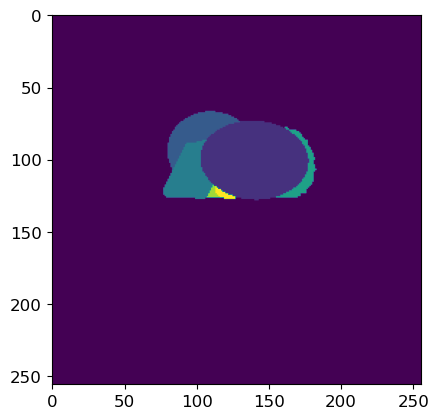

In [4]:
# the type is a subclass of tf.data.Dataset
print(f'Data has format: {type(train_data)}')

# Result is one training movie with the following
print(dict.keys(train_data), '\n')

# These are returned as EagerTensor
# The metadata contains
print(dict.keys(train_data['metadata']), '\n')

print(dict.keys(train_data['instances']), '\n')

print(train_data['instances']['category'], '\n')
print(train_data['segmentations'].shape, '\n')
print(train_data['instances']['asset_id'], '\n')
seg = train_data['segmentations'][0,:,:,:].numpy()
print(np.min(seg))
print(np.max(seg))
plt.imshow(train_data['segmentations'][0, :, :, :])

In [5]:
# Get the next video
train_data = next(iter_data)

## Let's look at segmentation Map as an example

Video:  0006
Video type:  fixed_random_rotate_003
forward_flow range -15.715254783630371 to 53.34239959716797
resolution: [<tf.Tensor: shape=(), dtype=int32, numpy=256>, <tf.Tensor: shape=(), dtype=int32, numpy=256>]
num_frames: 24


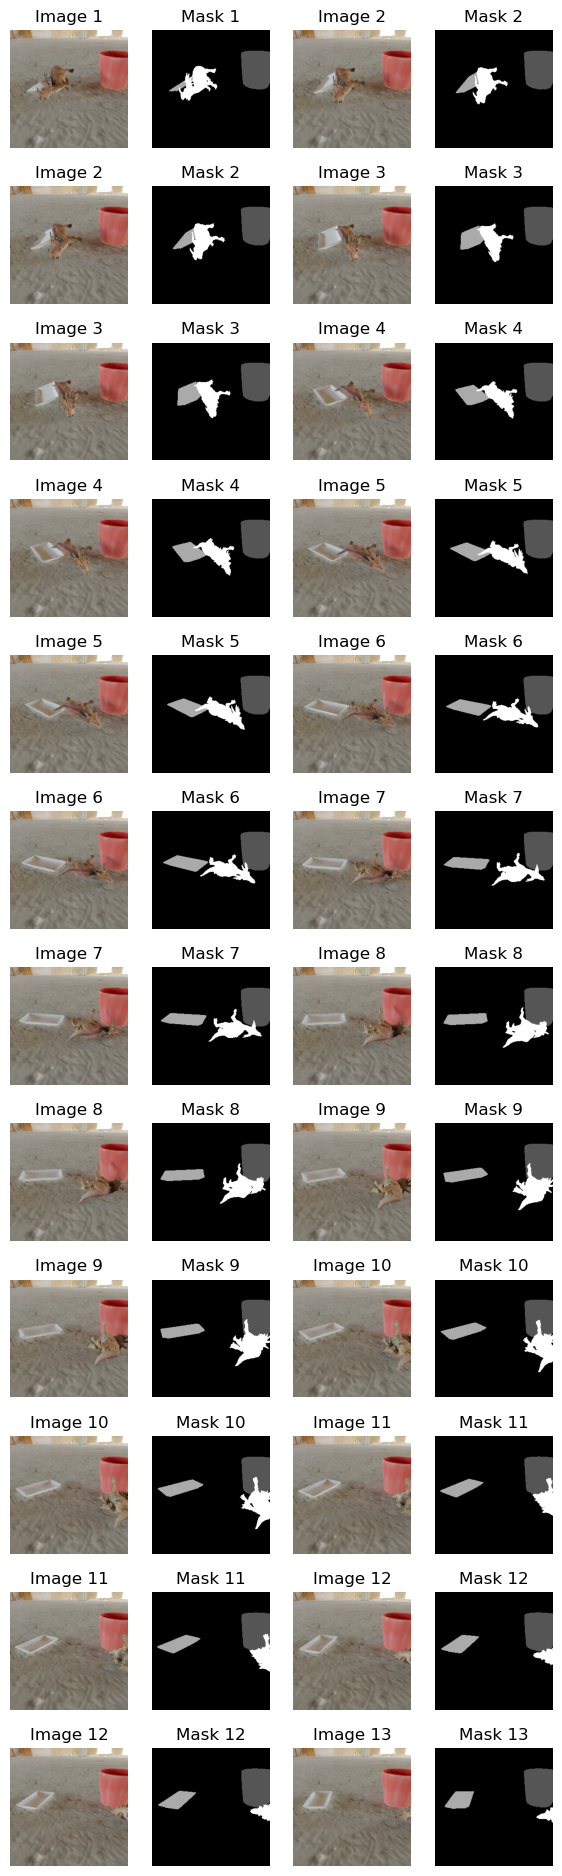

Saving figure 0006_seg


In [6]:
video_name, video_type = get_video_names( train_data['metadata'] )
f_scale, f_offset = get_scale_offset( train_data['metadata'] )

num_frames = int(train_data['metadata']['num_frames'])
resolution = [train_data['metadata']['height'], train_data['metadata']['width']]

print('resolution:', resolution)
print('num_frames:', num_frames)

x_mesh = np.empty(1)
y_mesh = np.empty(1)        


rows = num_frames // 2 + num_frames % 2  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, 4, figsize=(7, 2 * rows))

# Flatten axes for easier indexing
axes = axes.flatten()

for i in range(0, len(axes), 4):
    idx = i // 4  # Calculate the original index

    # Check if we still have images to plot
    if idx < num_frames:
        # Show first image
        axes[i].imshow(train_data['video'][idx, :, :, :])
        axes[i].set_title(f'Image {idx + 1}')
        axes[i].axis('off')

        # Show first mask
        axes[i + 1].imshow(train_data['segmentations'][idx, :, :, :].numpy(), cmap='gray')
        axes[i + 1].set_title(f'Mask {idx + 1}')
        axes[i + 1].axis('off')

    # Check if we still have a second image to plot
    if idx + 1 < num_frames:
        # Show second image
        axes[i + 2].imshow(train_data['video'][idx + 1, :, :, :])
        axes[i + 2].set_title(f'Image {idx + 2}')
        axes[i + 2].axis('off')

        # Show second mask
        axes[i + 3].imshow(train_data['segmentations'][idx + 1, :, :, :].numpy(), cmap='gray')
        axes[i + 3].set_title(f'Mask {idx + 2}')
        axes[i + 3].axis('off')

# Show the plot
plt.show()
save_video_fig(fig, video_name + '_seg', video_type, IMAGE_DIR)


In [7]:
flow_data_set = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)

# Prepare the training dataset
train_dataset = flow_data_set['train']

# Define a function to extract frames and segmentation masks
def extract_frames_and_masks(item):
    video_frames = item['video']
    segmentation_masks = item['segmentations']
    # Unstack the video frames and segmentation masks along the first axis (time/frames)
    frames = tf.unstack(video_frames, axis=0)
    masks = tf.unstack(segmentation_masks, axis=0)
    return frames, masks

# Apply the function to the dataset
train_dataset = train_dataset.map(extract_frames_and_masks, num_parallel_calls=tf.data.AUTOTUNE)

# Flatten the dataset from (batch, frames) to a dataset of frames
train_dataset = train_dataset.flat_map(
    lambda frames, masks: tf.data.Dataset.from_tensor_slices((frames, masks))
)

# Shuffle, batch, and prefetch the dataset
buffer_size = 1000  # Adjust buffer_size according to your dataset size and memory constraints
batch_size = 32     # You can adjust batch size

train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
# Load the dataset
flow_data_set = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path, split='train')

# Prepare a list to hold the data
data = []

# Iterate over the dataset
for item in tfds.as_numpy(flow_data_set):
    video_frames = item['video']
    segmentation_masks = item['segmentations']
    
    # Iterate over each frame and its corresponding mask
    for idx, (frame, mask) in enumerate(zip(video_frames, segmentation_masks)):
        # Flatten the frame and mask for DataFrame storage, or use another method as needed
        frame_flattened = frame.flatten()
        mask_flattened = mask.flatten()
        
        # Append the data as a dict to the data list
        data.append({
            'frame_index': idx,
            'frame': frame_flattened,  # Storing flattened frames directly could be very memory-intensive
            'mask': mask_flattened     # Consider storing file paths or another identifier instead
        })

# Create the DataFrame
df = pd.DataFrame(data)

df

,frame_index,frame,mask
0,0,"[238, 200, 175, 235, 199, 171, 234, 199, 169, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[238, 200, 175, 235, 199, 171, 234, 199, 169, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[238, 200, 175, 235, 199, 171, 234, 199, 169, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[238, 200, 175, 235, 199, 171, 234, 199, 169, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[238, 200, 175, 235, 199, 171, 234, 199, 169, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
715,19,"[192, 80, 47, 196, 80, 47, 200, 82, 47, 203, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
716,20,"[192, 81, 47, 196, 80, 47, 200, 82, 47, 203, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
717,21,"[192, 81, 47, 196, 80, 47, 200, 82, 47, 203, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
718,22,"[192, 81, 47, 196, 80, 47, 200, 82, 47, 203, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


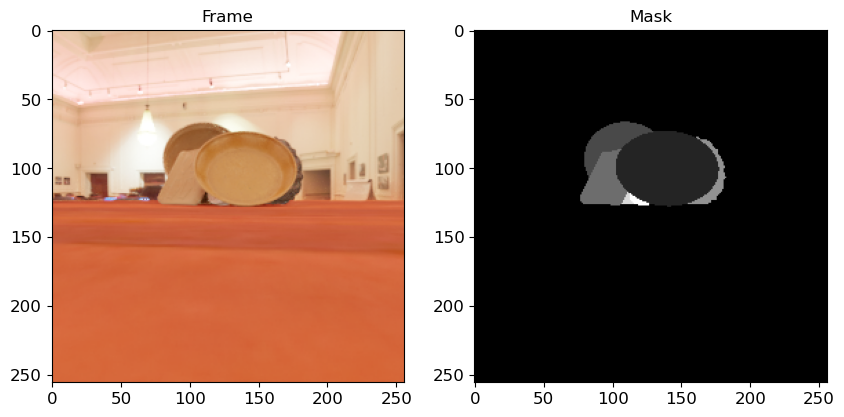

In [9]:
# Plot the first frame and its corresponding mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

resolution = (256, 256, 3)

# Plot the first frame
axes[0].imshow(df['frame'][0].reshape(resolution))
axes[0].set_title('Frame')

# Plot the first mask
axes[1].imshow(df['mask'][0].reshape(256, 256, 1), cmap='gray')
axes[1].set_title('Mask')

# Show the plot
plt.show()

## rotate frames

In [10]:
# Prepare a list to hold the data for the rotated DataFrame
rotated_data = []

# Iterate over the dataset
for item in tfds.as_numpy(flow_data_set):
    video_frames = item['video']
    segmentation_masks = item['segmentations']
    
    # Iterate over each frame and its corresponding mask
    for idx, (frame, mask) in enumerate(zip(video_frames, segmentation_masks)):
        # Flatten the frame and mask for DataFrame storage, or use another method as needed
        mask_flattened = mask.flatten()
        
        # Apply rotation to the frame
        rotated_frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE).flatten()
        
        # Append the data as a dict to the rotated data list
        rotated_data.append({
            'frame_index': idx,
            'rotated_frame': rotated_frame,
            'mask': mask_flattened
        })

# Create the rotated DataFrame
rotated_df = pd.DataFrame(rotated_data)


In [11]:
# Add frames from rotated_df as rows to df
df = pd.concat([df, rotated_df[['frame_index', 'rotated_frame','mask']].rename(columns={'rotated_frame': 'frame'})], ignore_index=True)

# Reset the index of the resulting dataframe if needed
df.reset_index(drop=True, inplace=True)


In [12]:
df

,frame_index,frame,mask
0,0,"[238, 200, 175, 235, 199, 171, 234, 199, 169, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[238, 200, 175, 235, 199, 171, 234, 199, 169, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[238, 200, 175, 235, 199, 171, 234, 199, 169, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[238, 200, 175, 235, 199, 171, 234, 199, 169, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[238, 200, 175, 235, 199, 171, 234, 199, 169, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1435,19,"[206, 94, 55, 204, 91, 53, 202, 89, 52, 200, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1436,20,"[206, 96, 56, 204, 90, 53, 202, 89, 52, 200, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1437,21,"[206, 93, 54, 204, 90, 52, 202, 89, 52, 200, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1438,22,"[207, 95, 56, 205, 91, 53, 202, 89, 53, 199, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
